AI_Translator
=

인공지능으로 번역기를 만드려는 시도는 끊임없이 있어왔습니다. 인공지능에서 딥러닝의 시대가 시작되고 기

### 목차
> 1. 목적 및 의의
> 2. 이론
> 3. 실습
> 4. 회고

## 1. 목적 및 의의
#### 1) Seq2seq 구조를 이해하고 이를 토대로 번역기를 만들어본다. 
#### 2) Attention 을 구현하여, 성능을 높여보고, 이를 이해한다.

## 2. 이론

## 3. 실습

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
# %config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm

# font = fm.FontProperties(fname=fontpath, size=9)
manager = fm.FontManager()
fm.fontManager.ttflist = manager.ttflist
plt.rc('font', family='NanumBarunGothic') 
# mpl.font_manager.findfont(font)


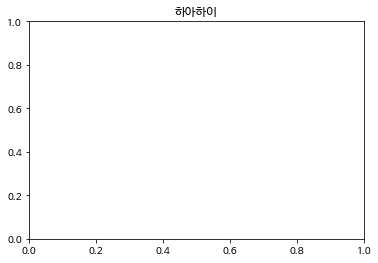

In [2]:
plt.figure()
plt.title("하아하이")
plt.show()

In [3]:
!nvidia-smi

Thu Aug 11 17:46:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.172.01   Driver Version: 450.172.01   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io


print(tf.__version__)

2.6.0


In [10]:
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz 
!wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.test.tar.gz

--2022-08-11 13:40:20--  https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz [following]
--2022-08-11 13:40:20--  https://raw.githubusercontent.com/jungyeul/korean-parallel-corpora/master/korean-english-news-v1/korean-english-park.train.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8718893 (8.3M) [application/octet-stream]
Saving to: ‘korean-english-park.train.tar.gz’

korean

In [11]:
!ls

aiffel	data  korean-english-park.test.tar.gz  korean-english-park.train.tar.gz


In [15]:
!tar xvzf korean-english-park.test.tar.gz
!tar xvzf korean-english-park.train.tar.gz

korean-english-park.test.en
korean-english-park.test.ko
korean-english-park.train.en
korean-english-park.train.ko


In [5]:
path_to_enfile = "korean-english-park.train.en"
path_to_kofile = "korean-english-park.train.ko"

In [6]:
with open(path_to_enfile, "r") as f:
    en_raw = f.read().splitlines()

with open(path_to_kofile, "r") as f:
    ko_raw = f.read().splitlines()

print("Data Size:", len(en_raw))
print("Example:")

for sen in list(zip(en_raw, ko_raw))[0:100][::20]: print(">>", *sen)

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?" 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations. 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said. "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project. 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes. 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 

In [7]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎㅏ-ㅣ가-힣0-9?.!,\s]+", "", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

print("슝~")

슝~


In [8]:
print(r"\1", "\1", "\\1")
r"\1", "\1", "\\1"

\1  \1


('\\1', '\x01', '\\1')

In [9]:
print("English:", en_raw[100]) 
print("Korean:", ko_raw[100])  

English: Gates, who opened the 23rd annual Comdex trade show, said there was a negative perception of high tech following the collapse of the tech bubble about two years ago.
Korean: 제 23차 연례 컴덱스 박람회의 개회사를 한 케이츠는 2년여전 기술 산업의 거품이 붕괴된 이후에 첨단 기술에 대해 부정적인 인식이 있다고 말했다.


In [10]:
en_raw, ko_raw = zip(*set(zip(en_raw,ko_raw)))

In [11]:
print("English:", en_raw[100]) 
print("Korean:", ko_raw[100])  

English: Expectations of change, whoever wins, are huge.
Korean: 누가 대통령으로 선출이 되든 모두들 새로운 변화에 많은 기대를 걸고 있다.


In [12]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', num_words=20000)
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [13]:
# 토큰화하기
enc_tensor, enc_tokenizer = tokenize(en_raw)
dec_tensor, dec_tokenizer = tokenize(ko_raw)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("English Vocab Size:", len(enc_tokenizer.index_word))
print("Korean Vocab Size:", len(dec_tokenizer.index_word))

English Vocab Size: 101881
Korean Vocab Size: 241331


### 같은 번역문임에도 불구하고 한국어의 단어 수가 더 많게 만들어지는 것이 도드라집니다.
### 형태소 분류기를 사용해 문제를 해결해봅니다.

### mecab 을 먼저 설치합니다.

In [25]:
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/v0.6.0/scripts/mecab.sh)

mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


In [14]:
from konlpy.tag import Mecab
from tqdm import tqdm

mecab = Mecab()

enc_corpus = []
dec_corpus = []

num_examples = len(en_raw)


for i in tqdm(range(num_examples)):
    enc_corpus.append(mecab.morphs(preprocess_sentence(ko_raw[i])))
    dec_corpus.append(["<start>"]+mecab.morphs(preprocess_sentence(en_raw[i]))+["<end>"])

print(enc_corpus[100])
print(dec_corpus[100])


100%|██████████| 78968/78968 [00:16<00:00, 4691.35it/s]

['누가', '대통령', '으로', '선출', '이', '되', '든', '모두', '들', '새로운', '변화', '에', '많', '은', '기대', '를', '걸', '고', '있', '다', '.']
['<start>', 'expectations', 'of', 'change', ',', 'whoever', 'wins', ',', 'are', 'huge', '.', '<end>']


In [15]:
def num_of_word(corpus):
    length_sen = [0]*len(corpus)
    for i, j in enumerate(corpus):
        length_sen[i] = len(j)
    return length_sen

from collections import Counter

def make_graph(length_sen,title=None):
    num_num = Counter(length_sen)
    plt.figure(figsize=(16,10))
    if title:
        plt.title(title)
    plt.bar(range(len(num_num)),[num_num[i] for i in range(len(num_num))],)
    plt.show()



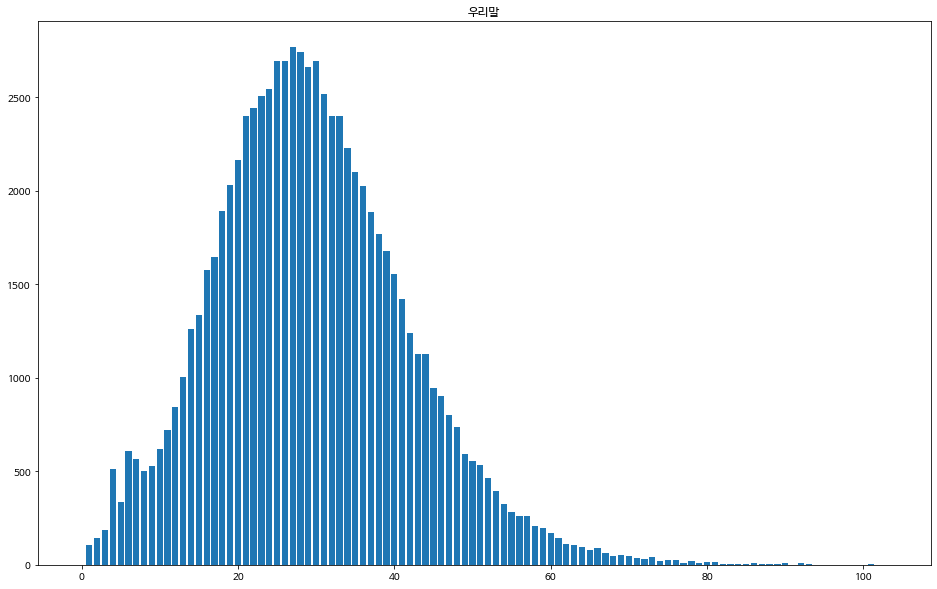

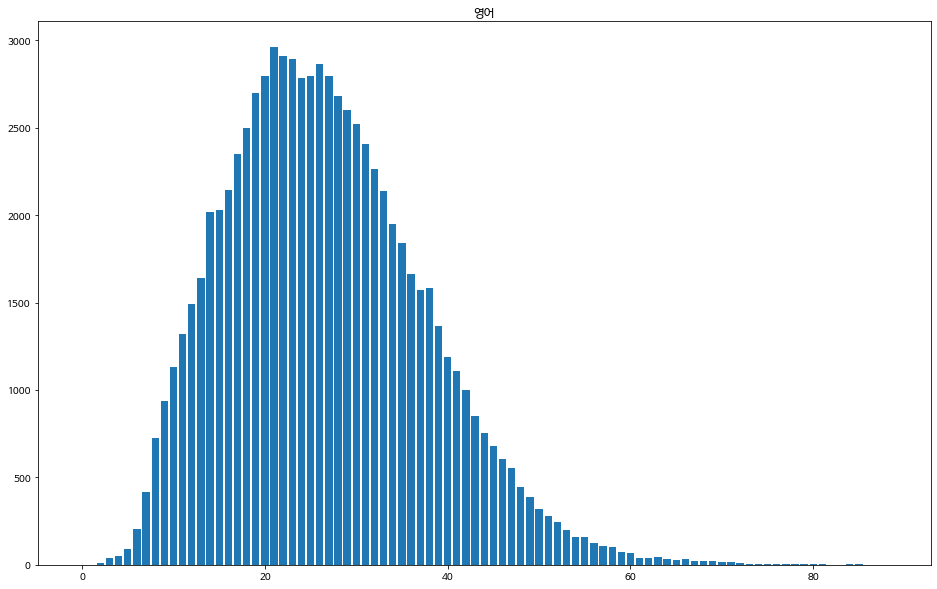

In [16]:
make_graph(num_of_word(enc_corpus),"우리말")
make_graph(num_of_word(dec_corpus),"영어")

### 문장 텐서의 길이가 답이 없이 길어지기 전에, 길이 제한을 좀 해보겠습니다.
### 많이 줄이지는 않을거지만, 학습에는 많은 이윤이 있을거 같아요.

In [17]:
new_enc = []
new_dec = []
for i,j in zip(enc_corpus, dec_corpus):
    if len(i) > 60 or len(j) > 60: continue
    new_enc.append(i)
    new_dec.append(j)

enc_corpus = new_enc
dec_corpus = new_dec


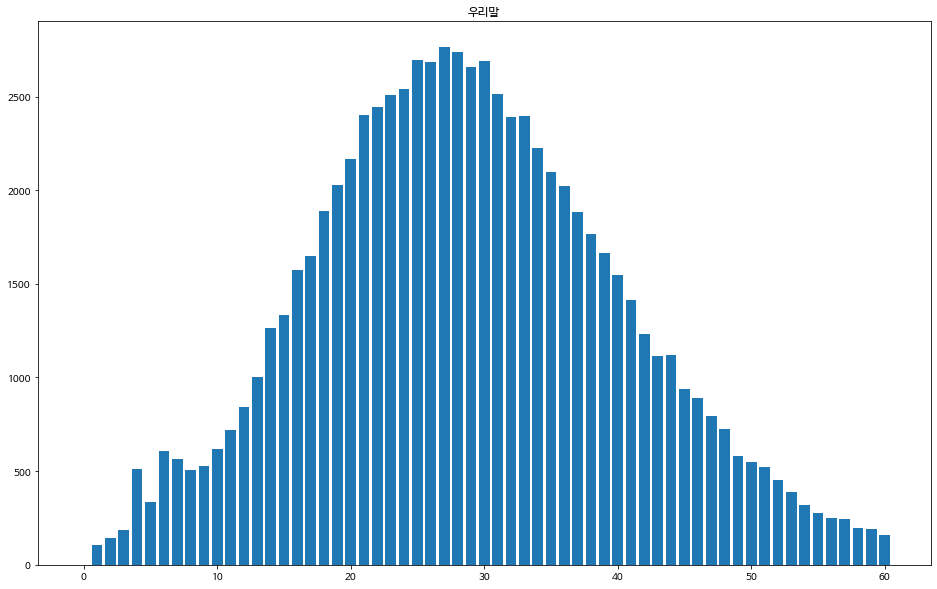

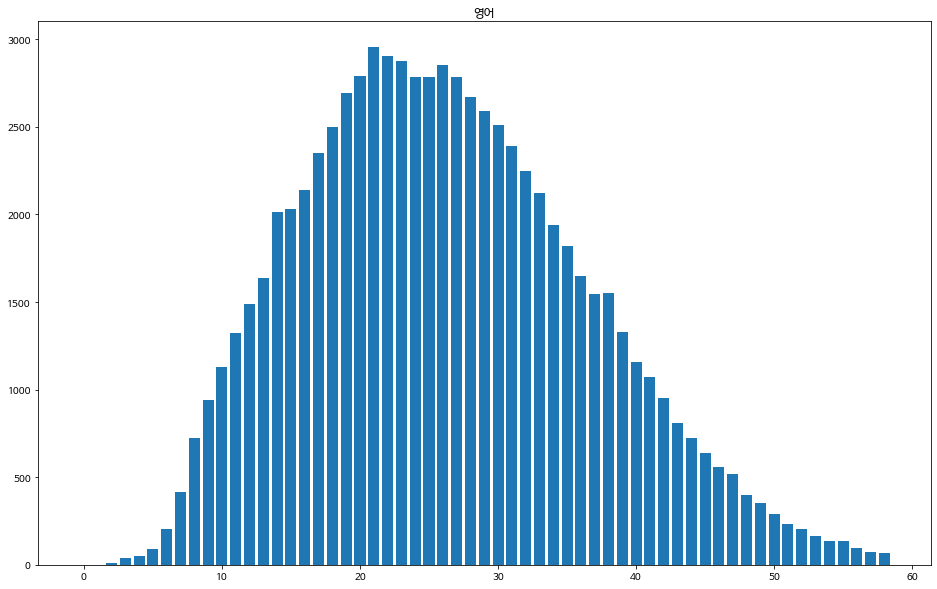

In [18]:
make_graph(num_of_word(enc_corpus),'우리말')
make_graph(num_of_word(dec_corpus), '영어')

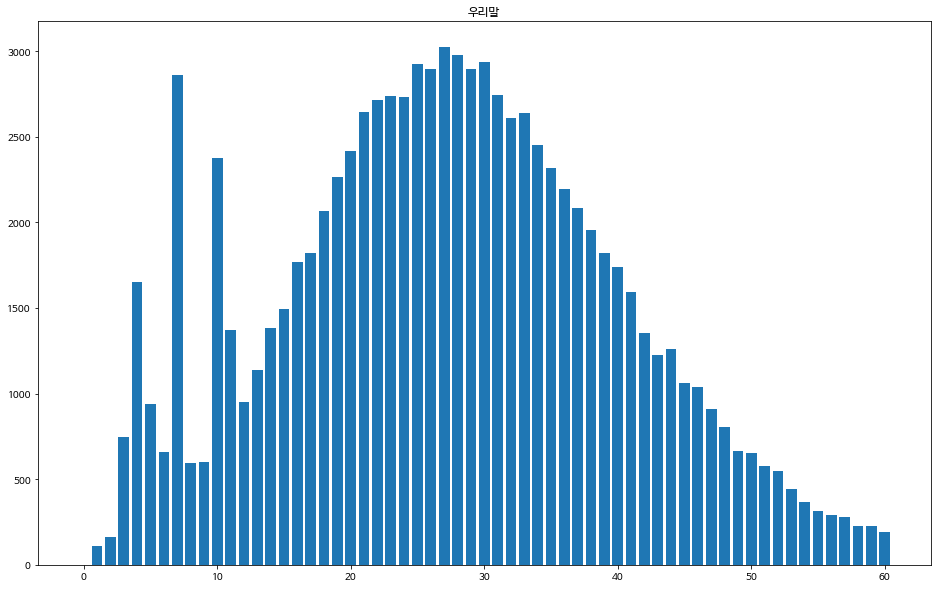

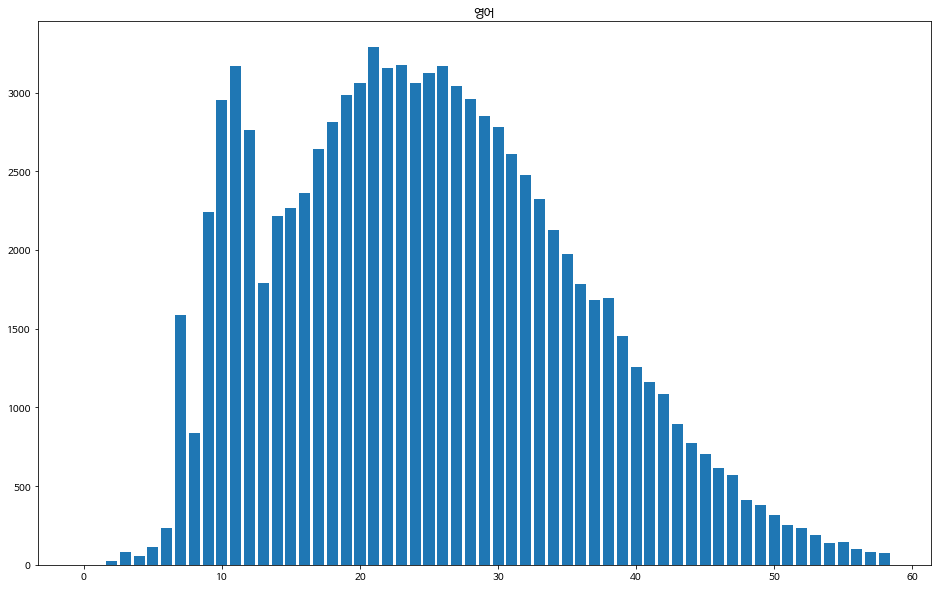

In [35]:
# 중복 제거 전
# make_graph(num_of_word(enc_corpus),'우리말')
# make_graph(num_of_word(dec_corpus), '영어')

In [19]:
# 토큰화하기- 형태소 버전
enc_tensor, enc_tokenizer = tokenize(enc_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

# 훈련 데이터와 검증 데이터로 분리하기
enc_train, enc_val, dec_train, dec_val = \
train_test_split(enc_tensor, dec_tensor, test_size=0.2)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

Korean Vocab Size: 52149
English Vocab Size: 52699


### 단어개수가 현저히 줄었을 뿐 아니라, 한글의 단어가 영어단어보다 적은 모습을 볼 수 있습니다.

In [20]:
BUFFER_SIZE = 32 #64
BATCH_SIZE = 32 #64

dataset = tf.data.Dataset.from_tensor_slices((enc_train,dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))

dataset = dataset.shuffle(BUFFER_SIZE, reshuffle_each_iteration=True)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
print(dataset)
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((32, 60), (32, 60)), types: (tf.int32, tf.int32)>


<BatchDataset shapes: ((32, 60), (32, 60)), types: (tf.int32, tf.int32)>

In [21]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


In [22]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out


In [23]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.SpatialDropout1D(0.4)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [24]:
# BATCH_SIZE     = 16
SRC_VOCAB_SIZE = 20000 # len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = 20000 # len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

Encoder Output: (32, 30, 1024)
Decoder Output: (32, 20000)
Decoder Hidden State: (32, 1024)
Attention: (32, 30, 1)


In [25]:
train_data = dataset.__iter__()
val_data = val_dataset.__iter__()

In [26]:
test = next(train_data)
test_x = test[0][:]
test_y = test[1][:]

In [27]:
print(test_x)

tf.Tensor(
[[  821    37  2071 ...     0     0     0]
 [  117   268     4 ...     0     0     0]
 [ 1998    29   752 ...     0     0     0]
 ...
 [ 7000 14038     9 ...     0     0     0]
 [ 2145    14     8 ...     0     0     0]
 [ 2158   977   343 ...     0     0     0]], shape=(32, 60), dtype=int32)


In [28]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


In [29]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss


@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss

print("슝~")

슝~


In [30]:
# Training Process
# train_step() 이후 eval_step() 진행하도록 소스 수정하기

from tqdm import tqdm
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0

    # val_data = val_dataset.__iter__() <- 수정 전 코드: 매우 부적절
    t = tqdm(dataset)

    for (idx, batch) in enumerate(t):
        batch_loss = train_step(*batch,
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (idx + 1)))
    
    test_loss = 0
    q = tqdm(val_dataset)

    for (idx, batch) in enumerate(q):
        test_batch_loss = eval_step(*batch,
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        q.set_description_str('Test Epoch %2d' % (epoch + 1))
        q.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (idx + 1)))

Test Epoch  1:  68%|██████▊   | 330/484 [01:25<00:31,  4.90it/s, Test Loss 2.7228]

In [47]:
# all out
del encoder
del decoder
del train_data

## 이걸로 몇번째 멈추는건지...ㅎㅎ

Input: can i have some coffee ?
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


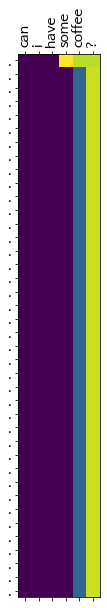

Input: i have a dream . thats you .
Predicted translation: . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 


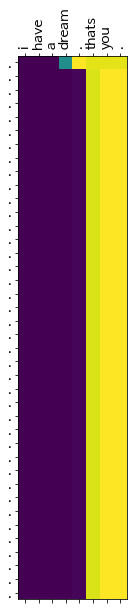

In [29]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)
translate("I have a Dream. that's you.", encoder, decoder)


### 이 결과를 보고 또 그냥 넘어갈 수는 없죠...
### dropout추가, hidden_states 2배, GRU_layer 2층으로 학습을 해보겠습니다.

In [34]:

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.SpatialDropout1D(0.4)
        self.gru1 = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
        self.gru2 = tf.keras.layers.GRU(enc_units,
                                       return_sequences=True)
    def call(self, x):
        out = self.embedding(x)
        out = self.dropout(out)
        out = self.gru1(out)
        out = self.gru2(out)
        
        return out

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.dropout = tf.keras.layers.SpatialDropout1D(0.4)
        self.gru1 = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.gru2 = tf.keras.layers.GRU(dec_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru1(out)
        self.dropout = tf.keras.layers.SpatialDropout1D(0.5)
        out, h_dec = self.gru2(out)

        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

# 코드를 실행하세요.

# BATCH_SIZE     = 16
SRC_VOCAB_SIZE = 20001  #len(enc_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = 20001  #len(dec_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)


슝~
Encoder Output: (64, 30, 1024)
Decoder Output: (64, 20001)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


In [35]:


# eval_step() 정의하기
# train_step() 이후 eval_step() 진행하도록 소스 수정하기
# Define eval_step

@tf.function
def eval_step(src, tgt, encoder, decoder, dec_tok):
    bsz = src.shape[0]
    loss = 0

    enc_out = encoder(src)

    h_dec = enc_out[:, -1]
    
    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
        pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

        loss += loss_function(tgt[:, t], pred)
        dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))
    
    return batch_loss


# Training Process

from tqdm import tqdm
import random

EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))[:-5]
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    train_data = dataset.__iter__()
    val_data = val_dataset.__iter__()

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(*next(train_data),
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))[:-5]
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(*next(val_data),
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch  5: 100%|██████████| 223/223 [01:47<00:00,  2.08it/s, Test Loss 3.9287]


Input: can i have some coffee ?
Predicted translation: <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


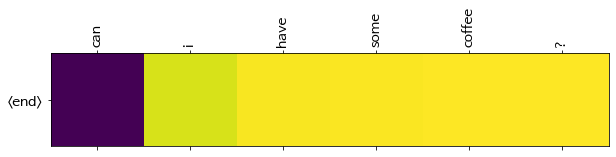

Input: i have a dream . thats you .
Predicted translation: <end> 


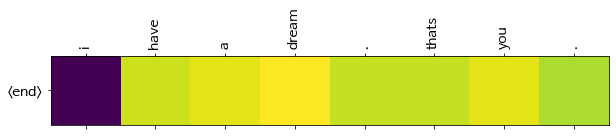

In [36]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)
translate("I have a Dream. that's you.", encoder, decoder)


In [37]:


checkpoint_dir = "/aiffel/Data/Model/translator"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(enc=encoder,
                                 dec=decoder)

checkpoint.save(file_prefix=checkpoint_prefix)



'/aiffel/Data/Model/translator/ckpt-1'

In [38]:

# checkpoint_dir = "/aiffel/Data/Model/translator"
# latest = tf.train.latest_checkpoint(checkpoint_dir)

# SRC_VOCAB_SIZE = 20001  #len(enc_tokenizer.index_word) + 1
# TGT_VOCAB_SIZE = 20001  #len(dec_tokenizer.index_word) + 1

# units         = 1024
# embedding_dim = 512

# encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
# decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# checkpoint = tf.train.Checkpoint(enc=encoder,
#                                  dec=decoder)
# checkpoint.restore(latest)

# encoder = checkpoint.encoder
# decoder = checkpoint.decoder


In [39]:
EPOCHS = 5

for epoch in range(EPOCHS):
    total_loss = 0

    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))[:-5]
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    train_data = dataset.__iter__()
    val_data = val_dataset.__iter__()

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(*next(train_data),
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 6))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    test_loss = 0
    
    idx_list = list(range(0, enc_val.shape[0], BATCH_SIZE))[:-5]
    random.shuffle(idx_list)
    t = tqdm(idx_list)

    for (test_batch, idx) in enumerate(t):
        test_batch_loss = eval_step(*next(val_data),
                                    encoder,
                                    decoder,
                                    dec_tokenizer)
    
        test_loss += test_batch_loss

        t.set_description_str('Test Epoch %2d' % (epoch + 6))
        t.set_postfix_str('Test Loss %.4f' % (test_loss.numpy() / (test_batch + 1)))

Test Epoch 10: 100%|██████████| 223/223 [01:46<00:00,  2.08it/s, Test Loss 3.9299]


In [40]:
checkpoint_dir = "/aiffel/Data/Model/translator"

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt2")
checkpoint = tf.train.Checkpoint(enc=encoder,
                                 dec=decoder)

checkpoint.save(file_prefix=checkpoint_prefix)


'/aiffel/Data/Model/translator/ckpt2-1'

Input: can i have some coffee ?
Predicted translation: <end> 


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator


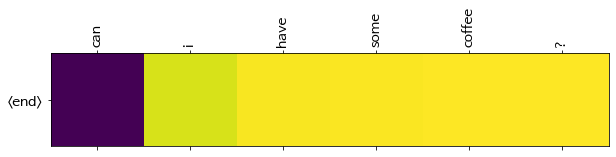

In [41]:
translate("Can I have some coffee?", encoder, decoder)


# 4. 회고
## 1) 일단... 아직은 학습 실패이다... 지금까지 배운걸 다 동원해서라도 학습에서 성공시키겠다..